# APF test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle

from swarm_prm.solvers.macro.swarm_teg.gaussian_prm import *
from swarm_prm.envs.map import Map, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Map(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(40, 0), (40, 40), (80, 40), (80, 0)]),
    Obstacle(None, "POLYGON", [(40, 100), (40, 50), (80, 50), (80, 100)])
]
num_samples = 100 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 1000
agent_radius = 2
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="HEXAGON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
# gaussian_prm.visualize_roadmap("test_map")
# gaussian_prm.visualize_g_nodes("test_g_nodes")

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)

In [3]:
import pickle
from swarm_prm.solvers.macro.swarm_teg.teg_nx import TEGGraph_NX

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

agent_radius = 2
num_agent= 1000

In [4]:
%%timeit
teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()

timestep: 0 max_flow: 0
timestep: 1 max_flow: 0
timestep: 2 max_flow: 0
timestep: 3 max_flow: 0
timestep: 4 max_flow: 0
timestep: 5 max_flow: 0
timestep: 6 max_flow: 0
timestep: 7 max_flow: 0
timestep: 8 max_flow: 0
timestep: 9 max_flow: 0
timestep: 10 max_flow: 0
timestep: 11 max_flow: 0
timestep: 12 max_flow: 0
timestep: 13 max_flow: 0
timestep: 14 max_flow: 0
timestep: 15 max_flow: 0
timestep: 16 max_flow: 0
timestep: 17 max_flow: 0
timestep: 18 max_flow: 0
timestep: 19 max_flow: 0
timestep: 20 max_flow: 0
timestep: 21 max_flow: 0
timestep: 22 max_flow: 2
timestep: 23 max_flow: 4
timestep: 24 max_flow: 6
timestep: 25 max_flow: 10
timestep: 26 max_flow: 14
timestep: 27 max_flow: 18
timestep: 28 max_flow: 22
timestep: 29 max_flow: 28
timestep: 30 max_flow: 34
timestep: 31 max_flow: 40
timestep: 32 max_flow: 46
timestep: 33 max_flow: 52
timestep: 34 max_flow: 58
timestep: 35 max_flow: 64
timestep: 36 max_flow: 70
timestep: 37 max_flow: 76
timestep: 38 max_flow: 82
timestep: 39 max_flow

In [5]:
print("max flow", max_flow)
print("timestep", timestep)

assert max_flow is not None, "Unable to find solution within the given timesteps"


# macro_sol = gaussian_prm.get_macro_solution(flow_dict)
# print(macro_sol)
simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)
with open("simple_paths.pkl", "wb") as f:
    pickle.dump(simple_paths, f)

NameError: name 'max_flow' is not defined

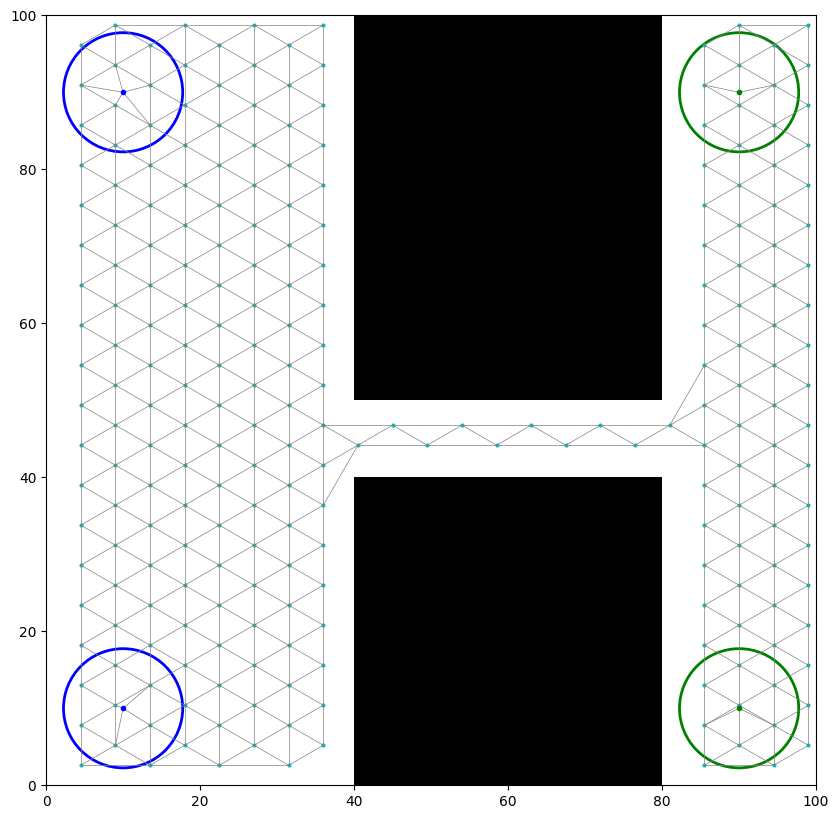

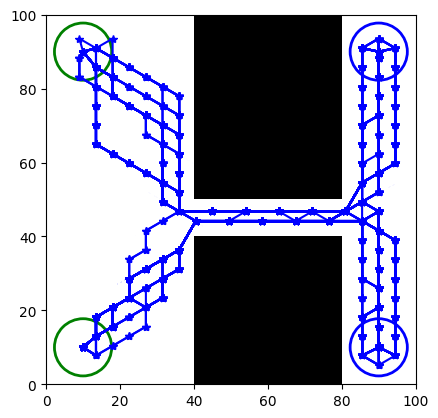

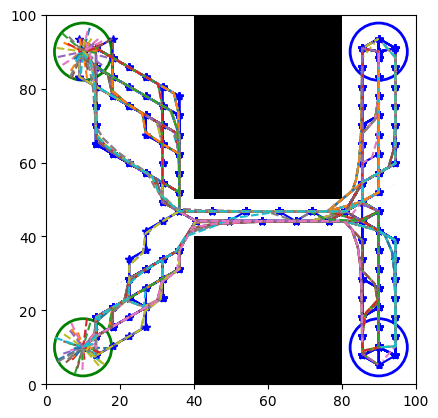

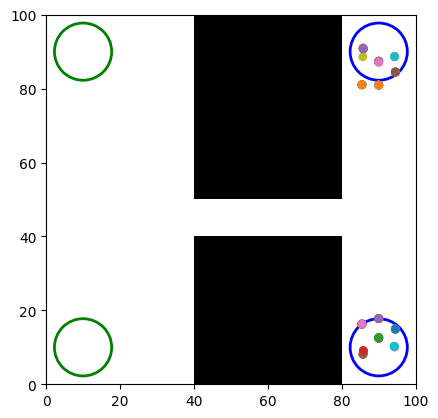

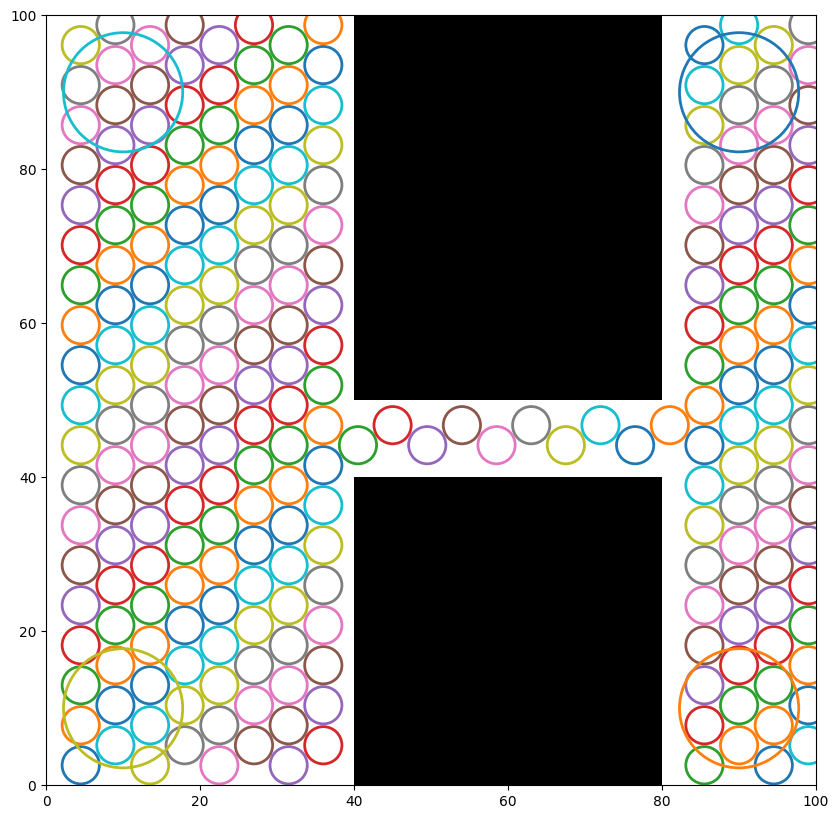

In [ ]:
gaussian_prm.visualize_g_nodes()
gaussian_prm.visualize_roadmap()
fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 

## APF

In [ ]:
import pickle
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro.apf_single_step import APFSingleStepSolver

with open("simple_paths.pkl", "rb") as f:
    simple_paths = pickle.load(f)

agent_radius = 1e-10
apf_solver = APFSingleStepSolver(roadmap, simple_paths, agent_radius, timestep, 
                                 step_size=0.1, max_timestep_iter=10, 
                                 ordering_strategy="GEOMETRY", 
                                 attract_coeff=0.3, repel_coeff=0.4, agent_repel_coeff=10,
                                 obs_thresh=1, reach_dist=5)
apf_path = apf_solver.get_solution()

fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")
# 
for i, path in enumerate(apf_path):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))

print(len(apf_path[0]))

In [ ]:
def animate_solution(fig, ax, speed):
    """
        Visualize solution trajectory provided instance
    """
    
    agents = []
    def init():
        for agent in agents:
            agent.remove()
        agents.clear()
        return []

    def update(frame):
        idx = frame * speed
        for agent in agents:
            agent.remove()
        agents.clear()
        cmap = plt.get_cmap("tab10")
        locs = [traj[idx] for traj in apf_path]
        for i, loc in enumerate(locs):
            agent = ax.add_patch(Circle(loc, radius=1, color=cmap(i%10)))
            agents.append(agent)
        return agents

    anim = FuncAnimation(fig, update, frames=len(apf_path[0]) // speed, 
                         init_func=init, blit=True, interval=100)
    anim.save("apf_solution.gif", writer='pillow', fps=6)

fig, ax = instance.visualize()
animate_solution(fig, ax, 30)

In [ ]:
import numpy as np
from shapely.geometry import Polygon, Point
from scipy.spatial import Voronoi, voronoi_plot_2d

def update_voronoi_with_repulsion(points, bounding_poly, repulsion_distance, alpha=0.1, beta=0.05, max_iterations=100):
    """
    Iteratively update Voronoi cell centroids with repulsive forces to avoid overlapping.
    - alpha: weight for centroids pull
    - beta: weight for repulsion forces
    - repulsion_distance: minimum distance between centroids before repulsion
    """
    for _ in range(max_iterations):
        # Step 1: Compute Voronoi diagram
        vor = Voronoi(points)
        
        # Initialize movement vector for each point
        movement = np.zeros_like(points)
        
        # Step 2: Calculate centroid of each Voronoi region
        for i, region_index in enumerate(vor.point_region):
            region = vor.regions[region_index]
            if -1 in region:  # Ignore infinite regions
                continue
            
            # Construct the polygon for the region
            vertices = [vor.vertices[i] for i in region]
            poly = Polygon(vertices).intersection(bounding_poly)
            if not poly.is_empty:
                centroid = np.array(poly.centroid)
                
                # Move towards the cell's centroid (Lloyd's relaxation)
                movement[i] += alpha * (centroid - points[i])
        
        # Step 3: Apply repulsive forces between centroids that are too close
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                distance = np.linalg.norm(points[i] - points[j])
                if distance < repulsion_distance:
                    # Calculate repulsive force
                    repulsion = beta * (points[i] - points[j]) / distance
                    movement[i] += repulsion
                    movement[j] -= repulsion
        
        # Step 4: Update point positions
        points += movement
        
    return points

# Example usage
initial_points = np.array([[1, 1], [5, 5], [3, 8], [7, 1]])  # Example initial centroids
bounding_poly = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])  # Bounding polygon
repulsion_distance = 1.0  # Minimum desired distance between centroids
updated_points = update_voronoi_with_repulsion(initial_points, bounding_poly, repulsion_distance)

print("Updated centroids:", updated_points)


Updated centroids: [[1 1]
 [5 5]
 [3 8]
 [7 1]]
